# Scorecard for climate bench app
code copied from https://github.com/google-research/weatherbenchX/blob/main/public_benchmark/WB_X_Website_Scorecard.ipynb

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np
import matplotlib as mpl
import fsspec
import pandas as pd


In [16]:
# To save figures
# SAVE_PATH = './'
# # Results paths
# RESULTS_PATH = 'gs://wb2-app-data/v4'  # No trailing slash

SAVE_PATH = '../../../ClimateBench_app/data/images'
RESULTS_PATH = '../../../ClimateBench_app/data'

In [17]:
# define helper function
def set_y_labels(ax, dataset, levels=True):
    ax.set_xticks([])
    if levels:
      ax.set_yticks(np.arange(len(dataset.level)))
      ax.set_yticklabels(dataset.level.values)
      # ax.tick_params(axis='y', which='major', pad=10)
    else:
      ax.set_yticks([0])
      ax.tick_params(axis='y', color='None')
      ax.set_yticklabels(['000'], color='None')

    ax.spines['top'].set_color('0.7')
    ax.spines['right'].set_color('0.7')
    ax.spines['bottom'].set_color('0.7')
    ax.spines['left'].set_color('0.7')

def add_white_lines(ax, img, color='white'):
  for i in range(img.shape[0]):
    for j in range(img.shape[1]):
      rect = mpl.patches.Rectangle(
          (j - 0.5, i - 0.5),
          1,
          1,
          linewidth=2,
          edgecolor=color,
          facecolor='None',
      )
      ax.add_patch(rect)

def set_x_labels(ax, dataset, labels=None):
  lead_time_h = int(dataset.lead_time[0] / np.timedelta64(1, 'h'))
  factor_24h = 24 // lead_time_h
  xticks = np.arange(0, len(dataset.lead_time), factor_24h)
  ax.set_xticks(xticks)
  # ax.set_xticklabels(xticks + 1 // factor_24h if labels is None else labels)
  ax.set_xticklabels(['Hist.', 'SSP2-4.5'])
  ax.spines['top'].set_color('0.7')
  ax.spines['right'].set_color('0.7')
  ax.spines['bottom'].set_color('0.7')
  ax.spines['left'].set_color('0.7')

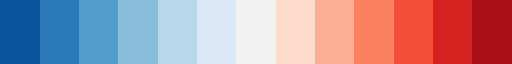

In [18]:
plt.rcParams['figure.facecolor'] = '0.9'
# reds = sns.color_palette('Reds', 7)
# blues = sns.color_palette('Blues_r', 7)
# cmap = matplotlib.colors.ListedColormap(blues + [(0.95, 0.95, 0.95)] + reds)
# cb_levels = [-50, -25, -15, -10, -5, -2, -1, 1, 2, 5, 10, 15, 25, 50]
reds = sns.color_palette('Reds', 6)
blues = sns.color_palette('Blues_r', 6)
cmap = matplotlib.colors.ListedColormap(blues + [(0.95, 0.95, 0.95)] + reds)
cb_levels = [-50, -20,-10, -5, -2, -1, 1, 2, 5, 10, 20, 50]
norm = matplotlib.colors.BoundaryNorm(cb_levels, cmap.N, extend='both')
cmap

In [34]:
def plot_main_scorecard(relative, absolute, variables, save_fn=None,
                        subselect_models=None, nphysical=None, nml=None,
                        custom_titles=None,
                        custom_names=None, custom_subtitles=None):
  matplotlib.rcParams.update(matplotlib.rcParamsDefault)

  models = subselect_models or absolute.model.values

  nmodels = len(models)
  nvariables = len(variables)

  panel_width = 2
  label_width = 1 * panel_width
  padding_right = 0.1

  panel_height = panel_width / 5

  title_height = panel_height * 1.25
  cbar_height = panel_height * 3
  spacing_height = panel_height * 0.1
  spacing_width = panel_height * 0.3

  total_width = label_width + nvariables * panel_width + (nvariables - 1) * spacing_width + padding_right
  total_height = title_height + cbar_height + nmodels * panel_height + (nmodels - 1) * spacing_height

  fig = plt.figure(figsize=(total_width, total_height))
  gs = mpl.gridspec.GridSpec(
      nmodels,
      nvariables,
      figure=fig,
      left=label_width / total_width,
      right=1 - padding_right / total_width,
      top=1-(title_height / total_height),
      bottom=cbar_height / total_height,
      # w/hspace are relative to average panel size
      hspace=spacing_height / panel_height,
      wspace=spacing_width / panel_width
  )
  for row, m in enumerate(models):
    for col, (var, l, metric) in enumerate(variables):
      ax = fig.add_subplot(gs[row, col])

      abs = absolute.sel(model=m, metric=metric)[var]
      da = relative.sel(model=m, metric=metric)[var]
      if l:
        da = da.sel(level=l)
        abs = abs.sel(level=l)
      values = da.sel(lead_time=lead_times).values[None, :]
      abs_values = abs.sel(lead_time=lead_times).values[None, :]
      img = ax.imshow(values, aspect='auto', cmap=cmap, norm=norm)
      set_y_labels(ax, da, levels=False)
      add_white_lines(ax, values, color='0.9')
      ax.grid(False)
      if col == 0:
        if custom_names is None:
          label = m.split(' vs')[0]
        else:
          label = custom_names[row]
        ax.set_ylabel(label, rotation='horizontal', horizontalalignment='right',
                      verticalalignment='center', labelpad=-20, zorder=10, fontsize=9.5)
        # Add physical model box
        if (nphysical is not None) and (row == nphysical-1):
          h=nphysical + (nphysical - 1) * spacing_height / panel_height
          rect = mpl.patches.Rectangle(
              (-0.98, 0), width=0.96, height=h, color="lightsteelblue", transform=ax.transAxes,
              clip_on=False, alpha=0.2, zorder=0.1
          )
          ax.add_patch(rect)
          if nphysical >=3:
            ax.text(-0.9, h/2, 'Physical models', ha='center',va='center',
                    transform=ax.transAxes, fontsize=8, rotation='vertical')
        # Add ML model box
        elif (nml is not None) and (row == nphysical + nml - 1):
          h=nml + (nml - 1) * spacing_height / panel_height
          rect = mpl.patches.Rectangle(
              (-0.98, 0), width=0.96, height=h, color="lightcoral", transform=ax.transAxes,
              clip_on=False, alpha=0.2, zorder=0.1
          )
          ax.add_patch(rect)
          if nml >=3:
            ax.text(-0.9, h/2, 'ML / hybrid models', ha='center',va='center',
                    transform=ax.transAxes, fontsize=8, rotation='vertical')
        else:
          ax.set_zorder(10)
      if row == 0:

        ax.set_title(custom_titles[col], fontsize=10, pad=17)
        ax.text(0.5, 1.25, custom_subtitles[col], ha='center',va='center', transform=ax.transAxes,
                fontsize=6)
      if (np.isnan(values).all()) & (row != 0):
        ax.remove()
        continue



      if row == nmodels - 1:
        lead_time_in_days = absolute.lead_time.values.astype('timedelta64[h]').astype(int) // 24
        set_x_labels(ax, da, labels=lead_time_in_days)
        ax.set_xlabel('Evalution Period')
      # Add absolute numbers
      for i, v in enumerate(abs_values[0]):
        if m == 'Climatology vs ERA5':
          v = np.mean(abs_values)
        if np.isfinite(v):
          if var == 'Specific Humidity': v *= 1000
          if var == '24h Precipitation' and metric == 'CRPS': v *= 1000

          if v > 10:
            v = str(v)[:3].rstrip('.')
          else:
            v = str(v)[:4]
          ax.text(i, 0, v, ha='center',va='center', fontsize=8)

  rel_cbar_height = cbar_height / total_height
  cax = fig.add_axes((0.35, rel_cbar_height * 0.4, 0.5, rel_cbar_height * 0.1))
  cb = fig.colorbar(img, cax=cax, orientation='horizontal', fraction=0.01)
  cb.ax.set_xticks(cb_levels)
  if '24h Precipitation' in np.ravel(variables):
    cb.ax.set_xlabel(r'Better % difference in RMSE/SEEPS vs IFS HRES Worse')
  else:
    cb.ax.set_xlabel(r'% difference in RMSE vs median RMSE')

  if save_fn:
    with fsspec.open(f'{SAVE_PATH}/{save_fn}', 'wb', auto_mkdir=True) as f:
      # fig.patch.set_facecolor('gray')
      plt.savefig(f, dpi=300)

      plt.close()
     

# Data preprocessing functions

In [35]:

def replace_analysis_with_era_precip(results):
  # Since vs Analysis doesn't have precip scores, replace vs analysis precip scores with ERA precip scores
  precip_variables = ['6h Precipitation', '24h Precipitation']
  for model in results.model.values:
    if model.endswith('vs Analysis'):
      model_vs_era = model.replace('vs Analysis', 'vs ERA5')
      if model_vs_era in results.model.values:
        for v in precip_variables:
          results[v].loc[dict(model=model)] = results[v].sel(dict(model=model_vs_era))
  return results

In [36]:
def compute_relative_results(results, reference_model):
  # Compute relative result
  reference = results.sel(model=reference_model, drop=True)
  relative = ((results - reference) / reference * 100)
  return relative

# Deterministic

In [37]:
# lead_times = np.array([1, 2], dtype='timedelta64[D]')
# models = [
#     'IFS HRES vs Analysis',
#     'IFS ENS (mean) vs Analysis',
#     'ERA5-Forecasts vs ERA5',
#     'Pangu-Weather (oper.) vs Analysis',
#     'GraphCast (oper.) vs Analysis',
#     'GenCast (oper.) (mean) vs Analysis',
#     # 'GenCast 100m U/V (oper.) (mean) vs Analysis',
#     'Keisler (2022) vs ERA5',
#     'Pangu-Weather vs ERA5',
#     'GraphCast vs ERA5',
#     'FuXi vs ERA5',
#     'NeuralGCM 0.7 vs ERA5',
#     'NeuralGCM ENS (mean) vs ERA5',
#     'GenCast (mean) vs ERA5',
#     'Stormer ENS (mean) vs ERA5',
#     'Excarta (HEAL-ViT) vs ERA5',
#     # 'Swin vs ERA5',
#     'ArchesWeather-Mx4 vs ERA5',
#     'ArchesWeatherGen (mean) vs ERA5',
#     'Climatology vs ERA5'
# ]

In [38]:
# results = xr.open_zarr(f'{RESULTS_PATH}/deterministic.zarr').compute()
# # Make all coarse selections
# results = results.sel(lead_time=lead_times, region='Global', year='2020', resolution='240x121')
# results = replace_analysis_with_era_precip(results)
# relative = compute_relative_results(results, 'IFS HRES vs Analysis')

# # Pick models
# results = results.sel(model=models)
# relative = relative.sel(model=models)

In [39]:
lead_times = np.array([1, 2], dtype='timedelta64[D]')

In [40]:
results = pd.read_csv(f'{RESULTS_PATH}/benchmark_results.csv').drop(columns=['Unnamed: 0','Change (hist 2005)','Percent Change (hist 2005)'])
results = results[(results['region']=='global') & (results['metric']=='zonal_mean_rmse')]
tas_ref = pd.concat([results.loc[results['variable'] == 'tas','Historical (2005-2014)'],results.loc[results['variable'] == 'tas','SSP2-4.5']]).median()
pr_ref = pd.concat([results.loc[results['variable'] == 'pr','Historical (2005-2014)'],results.loc[results['variable'] == 'pr','SSP2-4.5']]).median()
tos_ref = pd.concat([results.loc[results['variable'] == 'tos','Historical (2005-2014)'],results.loc[results['variable'] == 'tos','SSP2-4.5']]).median()
clt_ref = pd.concat([results.loc[results['variable'] == 'clt','Historical (2005-2014)'],results.loc[results['variable'] == 'clt','SSP2-4.5']]).median()
od550aer_ref = pd.concat([results.loc[results['variable'] == 'od550aer','Historical (2005-2014)'],results.loc[results['variable'] == 'od550aer','SSP2-4.5']]).median()

In [41]:
relative = results.copy()
relative['reference_value'] = tas_ref
relative.loc[relative['variable'] == 'pr','reference_value'] = pr_ref
relative.loc[relative['variable'] == 'tos','reference_value'] = tos_ref
relative.loc[relative['variable'] == 'clt','reference_value'] = clt_ref
relative.loc[relative['variable'] == 'od550aer','reference_value'] = od550aer_ref

relative['hist_relative'] = (relative['Historical (2005-2014)'] - relative['reference_value']) * 100 / relative['reference_value']
relative['ssp_relative'] = (relative['SSP2-4.5'] - relative['reference_value']) * 100 / relative['reference_value']

relative = relative.drop(columns=['region','Historical (2005-2014)','SSP2-4.5','reference_value','metric'])
relative['level'] = 1000
relative['metric'] = 'RMSE'
hist_rel = relative.drop(columns=['ssp_relative']).rename(columns={'hist_relative':'value'})
hist_rel['lead_time'] = lead_times[0]
ssp_rel = relative.drop(columns=['hist_relative']).rename(columns={'ssp_relative':'value'})
ssp_rel['lead_time'] = lead_times[1]

relative = pd.concat([
    hist_rel,
    ssp_rel
])
relative_ds = relative.pivot_table(index=['model','level','lead_time','metric'],columns='variable',values='value').to_xarray()
# dims: model, level, lead_time, metric

relative_ds = relative_ds.rename({'clt':'Cloud Area Fraction','tas':'Temperature','pr':'Precipitation','tos':'Sea Surface Temperature','od550aer':'Aerosol Optical Depth'})

In [42]:

results = results.drop(columns=['region'])
results['level'] = 1000
results['metric'] = 'RMSE'
hist_res = results.drop(columns=['SSP2-4.5']).rename(columns={'Historical (2005-2014)':'value'})
hist_res['lead_time'] = lead_times[0]
ssp_res = results.drop(columns=['Historical (2005-2014)']).rename(columns={'SSP2-4.5':'value'})
ssp_res['lead_time'] = lead_times[1]

results = pd.concat([
    hist_res,
    ssp_res
])
results_ds = results.pivot_table(index=['model','level','lead_time','metric'],columns='variable',values='value').to_xarray()
# dims: model, level, lead_time, metric

results_ds = results_ds.rename({'clt':'Cloud Area Fraction','tas':'Temperature','pr':'Precipitation','tos':'Sea Surface Temperature','od550aer':'Aerosol Optical Depth'})

In [43]:
nphysical = 0
upper_variables = [
    ('Temperature', 1000, 'RMSE'),
    ('Precipitation', 1000, 'RMSE'),
    ('Sea Surface Temperature', 1000, 'RMSE'),
    ('Cloud Area Fraction', 1000, 'RMSE'),
    ('Aerosol Optical Depth', 1000, 'RMSE'),
]
upper_titles = ['Temperature', 'Precipitation', 'Sea Surface Temperature', 'Cloud Area Fraction',  'Aerosol Opticial Depth',]
upper_subtitles = ['2M Temperature (K)', 'Surface Precipitation (kg/m2s)','Temperature (C)', 'Total Cloud Area Fraction (%)','Total Optical Depth at 550 nm',]

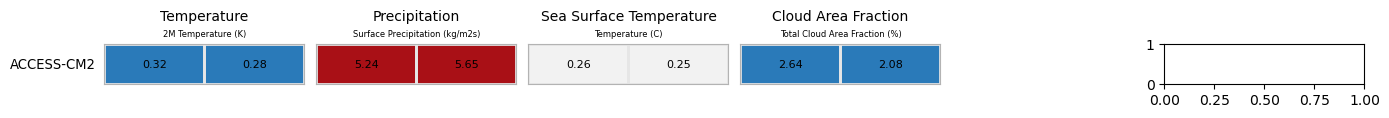

In [44]:
plot_main_scorecard(
    relative_ds,
    results_ds,
    variables=upper_variables,
    nphysical=nphysical,
    nml=0,
    custom_titles=upper_titles,
    custom_subtitles=upper_subtitles,
    save_fn='deterministic_upper.png'
)
plt.show()